# POMO Time Series Forecasting

Time Series Forecasting with 

In [24]:
# Load the library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [25]:
# Load the dataset
df = pd.read_csv("POMO_dataset/Historical Weather Data 2010-2021_preprocessed_2.csv")
df.head()

,observation,date,month,year,tempC_7to8,tempC_1to2,tempC_6to7,tempC_avg(0C),Relative humidity_7to8,Relative humidity_1to2,...,soil_pH,water_pH,water_TDS_mgpl,Label (Disease Yes/No),Type of Disease (Bacterial Blight/Telya),Anthracnose,Fruit Spot/ Rot,Fusarium Wilt,Fruit Borer / Blight Blora,NewLabel
0,2010-01-01,1,1,2010,20,30,20,23,42,33,...,6.91,7.18,1709.0,0,0,0,0,0,0,0
1,2010-01-02,2,1,2010,23,29,23,25,49,40,...,6.77,7.66,1707.0,1,1,1,0,0,0,24
2,2010-01-03,3,1,2010,24,27,21,24,61,50,...,6.76,7.44,1707.0,0,0,0,0,0,0,0
3,2010-01-04,4,1,2010,23,29,20,24,57,30,...,7.10,7.43,1708.0,0,0,0,0,0,0,0
4,2010-01-05,5,1,2010,22,30,21,24,48,34,...,6.53,8.05,1709.0,0,0,0,0,0,0,0


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4178 entries, 0 to 4177
Data columns (total 40 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   observation                               4178 non-null   object 
 1   date                                      4178 non-null   int64  
 2   month                                     4178 non-null   int64  
 3   year                                      4178 non-null   int64  
 4   tempC_7to8                                4178 non-null   int64  
 5   tempC_1to2                                4178 non-null   int64  
 6   tempC_6to7                                4178 non-null   int64  
 7   tempC_avg(0C)                             4178 non-null   int64  
 8   Relative humidity_7to8                    4178 non-null   int64  
 9   Relative humidity_1to2                    4178 non-null   int64  
 10  Relative humidity_6to7              

In [27]:
df.columns

Index(['observation', 'date', 'month', 'year', 'tempC_7to8', 'tempC_1to2',
       'tempC_6to7', 'tempC_avg(0C)', 'Relative humidity_7to8',
       'Relative humidity_1to2', 'Relative humidity_6to7',
       'Relative humidity_avg(%)', 'windspeedKmph_7to8', 'windspeedKmph_1to2',
       'windspeedKmph_6to7', 'windspeedKmph_avg(Km/h)', 'pressureMB_7to8',
       'pressureMB_1to2', 'pressureMB_6to7', 'pressureMB_avg', 'precipMM_7to8',
       'precipMM_1to2', 'precipMM_6to7', 'precipMM_avg(mm)',
       'weatherDesc_7to8', 'weatherDesc_1to2', 'weatherDesc_6to7',
       'weatherDesc', 'Sunshine Hours', '%_soil_moisure', 'soil_pH',
       'water_pH', 'water_TDS_mgpl', 'Label (Disease Yes/No)',
       'Type of Disease (Bacterial Blight/Telya)', 'Anthracnose',
       'Fruit Spot/ Rot', 'Fusarium Wilt', 'Fruit Borer / Blight Blora',
       'NewLabel'],
      dtype='object')

In [28]:
# df = df[['observation', 'date', 'month', 'year', 'tempC_7to8', 'tempC_1to2',
#        'tempC_6to7', 'tempC_avg(0C)', 'Relative humidity_7to8',
#        'Relative humidity_1to2', 'Relative humidity_6to7',
#        'Relative humidity_avg(%)', 'windspeedKmph_7to8', 'windspeedKmph_1to2',
#        'windspeedKmph_6to7', 'windspeedKmph_avg(Km/h)', 'pressureMB_7to8',
#        'pressureMB_1to2', 'pressureMB_6to7', 'pressureMB_avg', 'precipMM_7to8',
#        'precipMM_1to2', 'precipMM_6to7', 'precipMM_avg(mm)',
#        'weatherDesc_7to8', 'weatherDesc_1to2', 'weatherDesc_6to7',
#        'weatherDesc', 'Sunshine Hours', '%_soil_moisure', 'soil_pH',
#        'water_pH', 'water_TDS_mgpl']]

In [29]:
df1 = df['tempC_avg(0C)']
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))
df1 = pd.DataFrame(df1, columns=['tempC_avg(0C)'])
df1.head()

,tempC_avg(0C)
0,0.30
1,0.40
2,0.35
3,0.35
4,0.35


In [30]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = [], []
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

[split into train test sets](https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/)

In [31]:
train, test, val = df1.iloc[:3000], df1.iloc[3000:4000], df1.iloc[4000:]

test = test.reset_index(drop=True)
val = val.reset_index(drop=True)

In [32]:
# choose a number of time steps
n_steps = 30

# split into samples
X_train, y_train = split_sequence(train['tempC_avg(0C)'], n_steps)
X_test, y_test = split_sequence(test['tempC_avg(0C)'], n_steps)
X_val, y_val = split_sequence(val['tempC_avg(0C)'], n_steps)


# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))

In [35]:
# Vanilla LSTM for univariate time series forecasting
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit model
history = model.fit(X_train, y_train, 
                    validation_data = (X_test, y_test), 
                    shuffle = False,
                    epochs = 50, 
                    verbose = 1)

Epoch 1/50
93/93 [==============================] - 2s 14ms/step - loss: 0.1153 - val_loss: 0.0084
Epoch 2/50
93/93 [==============================] - 1s 11ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 3/50
93/93 [==============================] - 1s 11ms/step - loss: 0.0067 - val_loss: 0.0070
Epoch 4/50
93/93 [==============================] - 1s 11ms/step - loss: 0.0062 - val_loss: 0.0066
Epoch 5/50
93/93 [==============================] - 1s 11ms/step - loss: 0.0060 - val_loss: 0.0062
Epoch 6/50
93/93 [==============================] - 1s 11ms/step - loss: 0.0056 - val_loss: 0.0059
Epoch 7/50
93/93 [==============================] - 1s 11ms/step - loss: 0.0054 - val_loss: 0.0055
Epoch 8/50
93/93 [==============================] - 1s 11ms/step - loss: 0.0052 - val_loss: 0.0052
Epoch 9/50
93/93 [==============================] - 1s 11ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 10/50
93/93 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0048
Epoch 11/

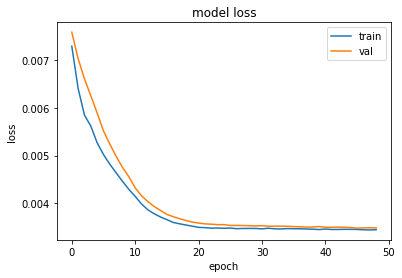

In [36]:
# # demonstrate prediction
# x_input = np.array([28,30,31,30,30,27,27,28,26,26,29,31,31,
#                     31,32,30,29,32,33,33,35,34,35,33,31,30,
#                     30,31,31,33])
# x_input = x_input.reshape((1, n_steps, n_features))
# yhat = model.predict(x_input)
# print(yhat)

plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val']) # , loc='upper left'
plt.savefig(f'model loss.png', bbox_inches='tight')
plt.show()


In [37]:
# Predicting For the next 30 data
# demonstrate prediction for next 30 days
x_input = np.array([X_test[0][i][0] for i in range(len(X_test[0]))])
# np.array([28,30,31,30,30,27,27,28,26,26,29,31,31,
#                     31,32,30,29,32,33,33,35,34,35,33,31,30,
#                     30,31,31,33])
temp_input = list(x_input)
lst_output = []
i = 0
next_days = 30

while (i < next_days):
    if(len(temp_input)>n_steps):
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        #print(x_input)
        x_input = x_input.reshape((1, n_steps, n_features))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.append(yhat[0][0])
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.append(yhat[0][0])
        i = i+1
    else:
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i = i+1

print(lst_output)

[0.3597925]
1 day input [0.3       0.3       0.3       0.35      0.4       0.3       0.3
 0.35      0.35      0.3       0.3       0.35      0.4       0.3
 0.35      0.35      0.4       0.4       0.4       0.4       0.4
 0.4       0.35      0.35      0.35      0.35      0.35      0.35
 0.35      0.3597925]
1 day output [[0.3671707]]
2 day input [0.3        0.3        0.35       0.4        0.3        0.3
 0.35       0.35       0.3        0.3        0.35       0.4
 0.3        0.35       0.35       0.4        0.4        0.4
 0.4        0.4        0.4        0.35       0.35       0.35
 0.35       0.35       0.35       0.35       0.3597925  0.36717069]
2 day output [[0.37232587]]
3 day input [0.3        0.35       0.4        0.3        0.3        0.35
 0.35       0.3        0.3        0.35       0.4        0.3
 0.35       0.35       0.4        0.4        0.4        0.4
 0.4        0.4        0.35       0.35       0.35       0.35
 0.35       0.35       0.35       0.3597925  0.36717069 0.37232

27 day output [[0.4145472]]
28 day input [0.35       0.35       0.3597925  0.36717069 0.37232587 0.37586126
 0.378492   0.38066733 0.38262126 0.38448173 0.38636097 0.38827878
 0.39018881 0.39205423 0.39386714 0.39563236 0.39735174 0.39898369
 0.40055111 0.40205783 0.40352246 0.40494281 0.40631863 0.40765384
 0.40894455 0.41018808 0.41136488 0.41248038 0.41353968 0.4145472 ]
28 day output [[0.41550466]]
29 day input [0.35       0.3597925  0.36717069 0.37232587 0.37586126 0.378492
 0.38066733 0.38262126 0.38448173 0.38636097 0.38827878 0.39018881
 0.39205423 0.39386714 0.39563236 0.39735174 0.39898369 0.40055111
 0.40205783 0.40352246 0.40494281 0.40631863 0.40765384 0.40894455
 0.41018808 0.41136488 0.41248038 0.41353968 0.4145472  0.41550466]
29 day output [[0.41641414]]
[0.3597925, 0.3671707, 0.37232587, 0.37586126, 0.378492, 0.38066733, 0.38262126, 0.38448173, 0.38636097, 0.38827878, 0.3901888, 0.39205423, 0.39386714, 0.39563236, 0.39735174, 0.3989837, 0.4005511, 0.40205783, 0.403522

In [38]:
len(lst_output)

30

In [39]:
len(y_test[:next_days])

30

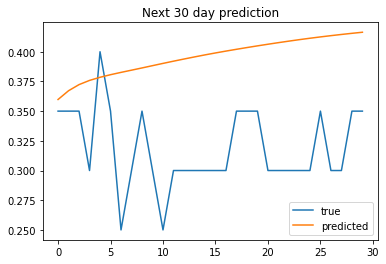

In [40]:
plt.figure(figsize=(15, 5))
plt.plot(np.arange(0,next_days),y_test[:next_days])
plt.plot(np.arange(0,next_days),lst_output)
plt.title('Next 30 day prediction')
plt.legend(['true', 'predicted']) # , loc='upper left'
plt.savefig(f'Next 30 day prediction.png', bbox_inches='tight')
plt.show()

In [43]:
yhat = model.predict(X_test)
# print(yhat)

ValueError: x and y must have same first dimension, but have shapes (970,) and (148, 1)

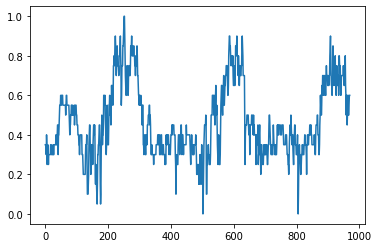

In [52]:
plt.figure(figsize=(15, 5))
plt.plot(np.arange(0,len(X_test)),y_test[:len(X_test)])
plt.plot(np.arange(0,len(X_test)),yhat)
plt.title('Prediction with test dataset')
plt.legend(['true', 'predicted']) # , loc='upper left'
plt.savefig(f'Prediction with test dataset.png', bbox_inches='tight')
plt.show()

In [51]:
evaluate_regression_model(y_test, yhat)

Mean Squared Error : 0.0 
Root Mean Squared Error : 0.06 
Mean Absolute Error : 0.04 
R^2 Score : 0.46 


{'Mean_Squared_Error': 0.0,
 'Root_Mean_Squared_Error': 0.06,
 'Mean_Absolute_Error': 0.04,
 'R2Score': 0.46}

In [44]:
yhat = model.predict(X_val)
# print(yhat)

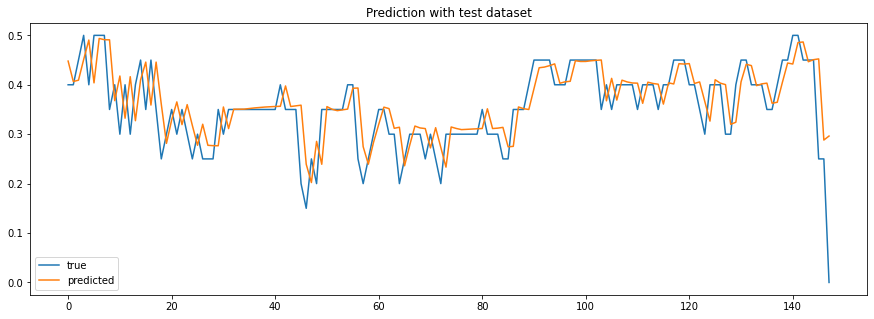

In [54]:
plt.figure(figsize=(15, 5))
plt.plot(np.arange(0,len(X_val)),y_val)
plt.plot(np.arange(0,len(X_val)),yhat)
plt.title('Prediction with val dataset')
plt.legend(['true', 'predicted']) # , loc='upper left'
plt.savefig(f'Prediction with val dataset.png', bbox_inches='tight')
plt.show()

In [46]:
# evaluate a regression model
def evaluate_regression_model(y, yhat):
    '''
    To evaluate regression model by using Mean Squared Error, 
    Root Mean Squared Error, Mean Absolute Error and R^2 Score.
    '''
    try:
        import math
        from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    except Exception as e:
        print(f"Exception [evaluate_regression_model] : {e} ")    
    Mean_Squared_Error = round(mean_squared_error(y, yhat), 2)
    Root_Mean_Squared_Error = round(math.sqrt(mean_squared_error(y, yhat)), 2)
    Mean_Absolute_Error = round(mean_absolute_error(y, yhat), 2)
    R2Score = round(r2_score(y, yhat), 2)
    print(f"Mean Squared Error : {Mean_Squared_Error} ")
    print(f"Root Mean Squared Error : {Root_Mean_Squared_Error} ")
    print(f"Mean Absolute Error : {Mean_Absolute_Error} ")
    print(f"R^2 Score : {R2Score} ")
    return {"Mean_Squared_Error" : Mean_Squared_Error, 
            "Root_Mean_Squared_Error" : Root_Mean_Squared_Error, 
            "Mean_Absolute_Error" : Mean_Absolute_Error, 
            "R2Score" : R2Score}

# evaluate_regression_model(y, yhat)

In [48]:
evaluate_regression_model(y_val, yhat)

Mean Squared Error : 0.0 
Root Mean Squared Error : 0.06 
Mean Absolute Error : 0.04 
R^2 Score : 0.46 


{'Mean_Squared_Error': 0.0,
 'Root_Mean_Squared_Error': 0.06,
 'Mean_Absolute_Error': 0.04,
 'R2Score': 0.46}